Cotton: Use cases: queries and visualizations
=====================

In [1]:
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import DCTERMS, DC, XSD, RDFS, DCAT, RDF, FOAF, NamespaceManager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
import contextily as ctx
import geopandas as gpd
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

def sparql_query_result_to_df(results):

    def parse_value(item):
        if '_datatype' in dir(item):
            if item.datatype == "http://www.w3.org/2001/XMLSchema#decimal":
                return float(item._value)
            if item.datatype == "http://www.w3.org/2001/XMLSchema#integer":
                return int(item._value)
            if item.datatype == "http://www.w3.org/2001/XMLSchema#dateTime":
                return datetime.datetime.strptime(item._value, '%Y-%m-%dT%H:%M:%SZ')
            return item._value
        else:
            return item

    results = results.bindings
    results = [{k.strip(): parse_value(v.strip()) for k, v in item.items()} for item in results]
    df = pd.DataFrame(results)
    return df

In [4]:
cottonGraph = Graph()
cottonGraph.parse("../creating-rdf/data/Legacy_Cotton_VT_data.csv.ttl", format="turtle")

<Graph identifier=N2627d745fb474ec3b345935128ac056d (<class 'rdflib.graph.Graph'>)>

## List of subjects

In [79]:
query = """
PREFIX agschemas: <https://agschemas.org/>
PREFIX schema: <https://schema.org/>

SELECT * WHERE {
   ?harvest agschemas:harvestedAt ?location.
   ?location schema:latitude ?latitude;
             schema:longitude ?longitude.
}
"""
dfresults = sparql_query_result_to_df(cottonGraph.query(query))

dfresults['geometry'] = [Point(xy) for xy in zip(dfresults.longitude, dfresults.latitude)]
dfresults

,harvest,location,latitude,longitude,geometry
0,http://cottonexample.org/1,http://cottonexample.org/location/Ac_Drip,32.7457,-101.9396,POINT (-101.9396 32.7457)
1,http://cottonexample.org/10,http://cottonexample.org/location/Ac_Drip,32.7457,-101.9396,POINT (-101.9396 32.7457)
2,http://cottonexample.org/100,http://cottonexample.org/location/Ac_Drip,32.7457,-101.9396,POINT (-101.9396 32.7457)
3,http://cottonexample.org/101,http://cottonexample.org/location/Ac_Drip,32.7457,-101.9396,POINT (-101.9396 32.7457)
4,http://cottonexample.org/102,http://cottonexample.org/location/Ac_Drip,32.7457,-101.9396,POINT (-101.9396 32.7457)
...,...,...,...,...,...
43619,http://cottonexample.org/9898,http://cottonexample.org/location/Charles_Ashb...,33.203,-101.8439,POINT (-101.8439 33.203)
43620,http://cottonexample.org/9899,http://cottonexample.org/location/Charles_Ashb...,33.203,-101.8439,POINT (-101.8439 33.203)
43621,http://cottonexample.org/9900,http://cottonexample.org/location/Charles_Ashb...,33.203,-101.8439,POINT (-101.8439 33.203)
43622,http://cottonexample.org/9901,http://cottonexample.org/location/Charles_Ashb...,33.203,-101.8439,POINT (-101.8439 33.203)


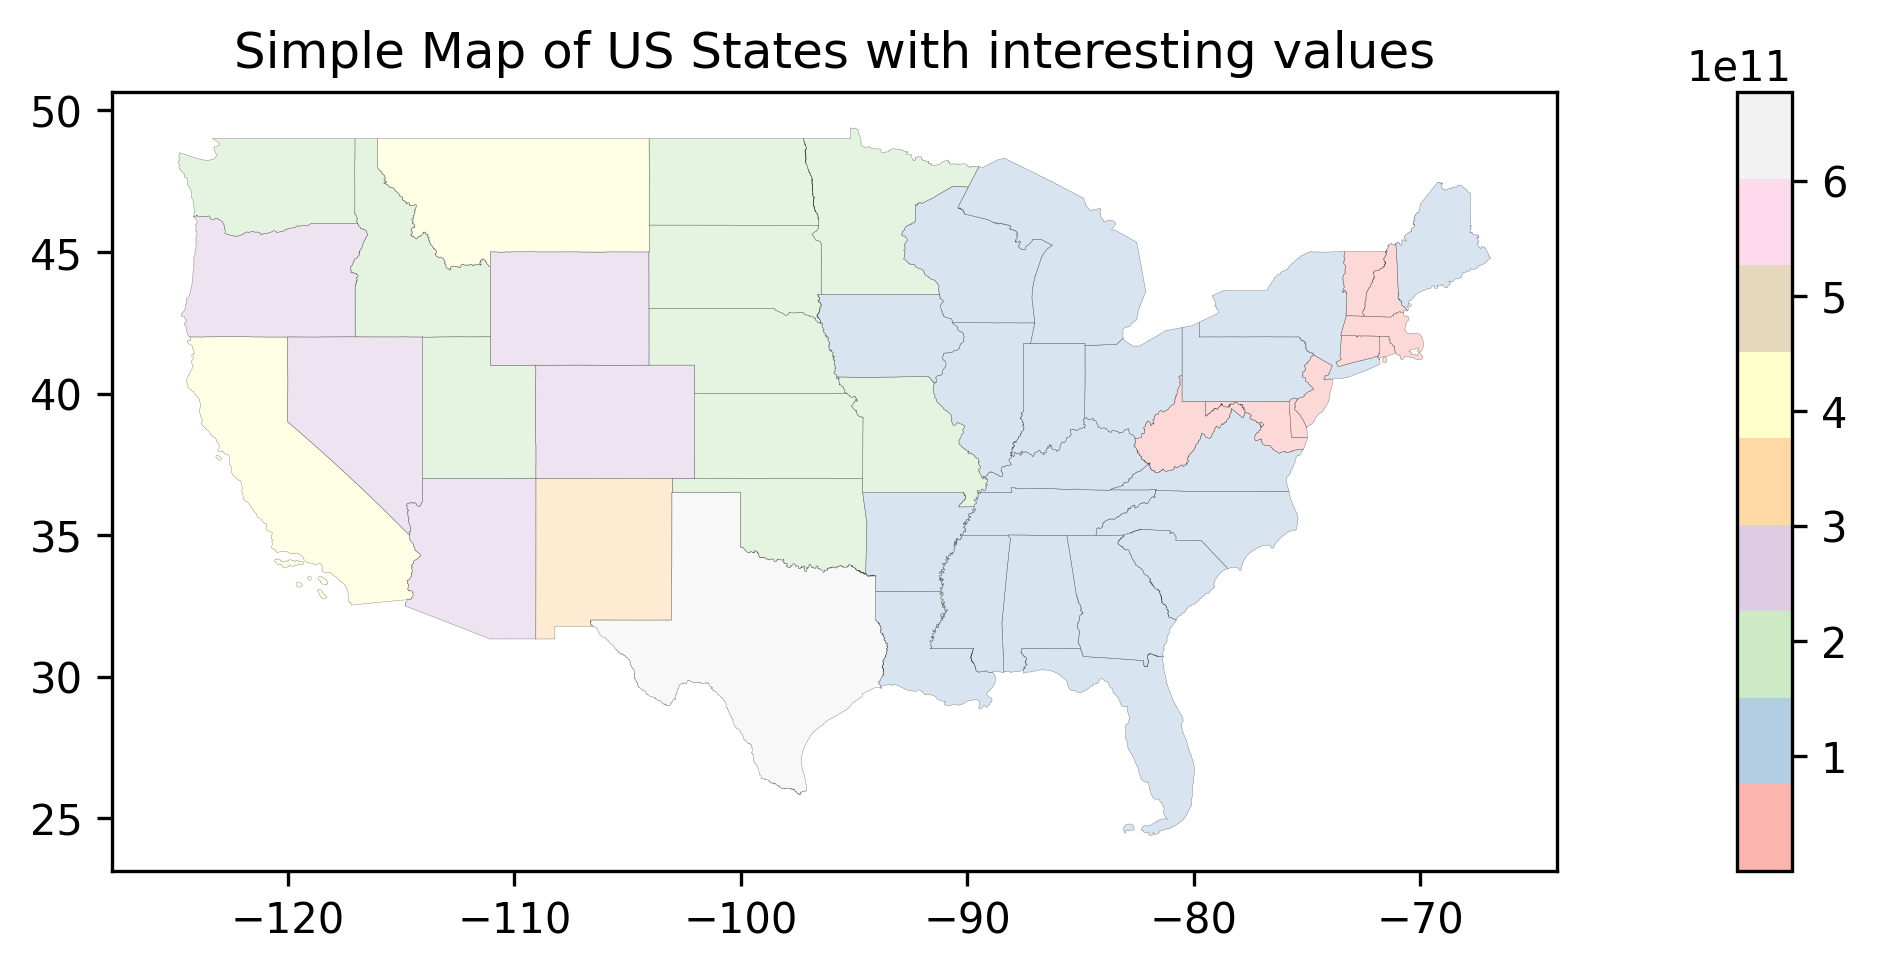

In [82]:
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Simple Map of US States with interesting values')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot('ALAND', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1)
plt.show()

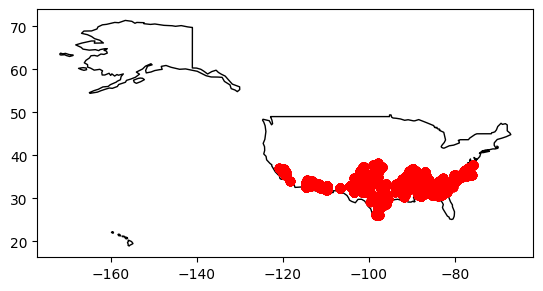

In [80]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.iso_a3 == 'USA'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.

gdf = gpd.GeoDataFrame(
    dfresults, geometry=gpd.points_from_xy(dfresults.longitude, dfresults.latitude))
gdf.plot(ax=ax, color='red')
plt.show()

In [96]:
query = """
PREFIX agschemas: <https://agschemas.org/>
PREFIX schema: <https://schema.org/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?location ?wikidatalink WHERE {
   ?harvest agschemas:harvestedAt ?location.
   ?location schema:isPartOf ?wikidatalink .
}
""" 
dfresults = sparql_query_result_to_df(cottonGraph.query(query))
dfresults

,location,wikidatalink
0,http://cottonexample.org/location/Ac_Drip,http://www.wikidata.org/entity/Q970422
1,http://cottonexample.org/location/AgriLife_Res...,http://www.wikidata.org/entity/Q49242
2,http://cottonexample.org/location/Charles_Parker,http://www.wikidata.org/entity/
3,http://cottonexample.org/location/Chase_Mahalitic,http://www.wikidata.org/entity/Q2387079
4,http://cottonexample.org/location/Chester_County,http://www.wikidata.org/entity/
...,...,...
645,http://cottonexample.org/location/Catahoula,http://www.wikidata.org/entity/
646,http://cottonexample.org/location/Catahoula_Caddo,http://www.wikidata.org/entity/
647,http://cottonexample.org/location/Chad_Boese,http://www.wikidata.org/entity/Q2005266
648,http://cottonexample.org/location/Chambers,http://www.wikidata.org/entity/
